# Documentation


Summary of our on-going tasks before using Streamlit /GitHub



1.   we prepare the data set to gain some memory
2.   we can keep from 2012-2016
3.   we run non-linear models such as GBC - RFC - KNN - SVM  
4.   We split the data set to remove 2016 and predicted it to see accurancy of our best model chosen
5.   After finalizning the model using best parameters, we will use the risk scoring to display the risk zones inside each agglo with a deep dive per catr and hrmn, etc ....
6.   clean-up the code 
7.   rerun the data visualization with the clean dataset

Classification Report:
for a given class:

• A high accuracy and high recall: The class was handled well by the model.

• A high precision and a low recall: The class is not well detected but when it is, the model is very reliable.

• A low accuracy and a high recall: The class is well detected, but also includes observations of other classes.

• A low precision and a low call: the class was not well managed at all.

Generally speaking we can consider that accuracy scores: 
- Over 90% - Very good. 
- Between 70% and 90% - Good. 
- Between 60% and 70% - OK.

# Importing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#int.cent.ml@gmail.com
#ic.....!

Mounted at /content/drive


In [2]:
from functools import reduce
from matplotlib import style
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, LassoCV,LinearRegression,RidgeCV,LogisticRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer, classification_report, make_scorer, recall_score, f1_score,r2_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingClassifier,GradientBoostingRegressor,HistGradientBoostingRegressor,VotingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
import datetime
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR


In [3]:
#READ DATASETS
df_c= pd.read_csv('drive/My Drive/RoadAccidentDT/caracteristics.csv' , sep=',' ,encoding='latin-1',low_memory=False)
df_p= pd.read_csv('drive/My Drive/RoadAccidentDT/places.csv' , sep=',' ,encoding='latin-1',low_memory=False)
df_h= pd.read_csv('drive/My Drive/RoadAccidentDT/holidays.csv' , sep=',' ,encoding='latin-1',low_memory=False)
df_v= pd.read_csv('drive/My Drive/RoadAccidentDT/vehicles.csv' , sep=',' ,encoding='latin-1',low_memory=False)
df_u= pd.read_csv('drive/My Drive/RoadAccidentDT/users.csv' , sep=',' ,encoding='latin-1',low_memory=False)

# Functions


In [4]:
#df_u[df_u['grav']==1].head()
#1. rmse function
def rmse(x,y): return np.sqrt(((x-y)**2).mean())

#2. scor function
def print_score(m):
  scorTrain='{:.3f}'.format(m.score(X_train, y_train)*100)
  errorTrain='{:.3f}'.format(rmse(m.predict(X_train), y_train))
  scortest='{:.3f}'.format(m.score(X_test, y_test)*100)
  errorTest='{:.3f}'.format(+rmse(m.predict(X_test), y_test))
  print('score train '+scorTrain+' '+'rmse train '+errorTrain)
  print('score test '+scortest+' '+'rsme test '+errorTest)

#3. Relative average error
def RAE(series1,series2):
  RAE = [(series1.iloc[i]-series2[i])/series1.iloc[i] for i in range(len(series1))]
  bias = sum(RAE) / len(series1)
  print('Bias: %f%%' % (bias*100))

# Merging Dataset

In [5]:
print(df_c['Num_Acc'].nunique())
print(df_p['Num_Acc'].nunique())
#Merging Caracteristics & Places
print('Caracteristics length: '+str(len(df_c)))
print('Places length: '+str(len(df_p)))
df_c_p=pd.merge(left=df_c,right=df_p, on='Num_Acc')
print('df_c_p: '+str(len(df_c_p)))

#fixing correct datetime format in df_caracteristics_places and holidays
#example of datetime 2022-12-27 08:26:49.219717
df_c_p['an'] = df_c_p['an'] + 2000
df_c_p['DateTime'] = df_c_p['an'].astype(str) + "-" + df_c_p['mois'].astype(str) + "-" + df_c_p['jour'].astype(str)+' '+(df_c_p['hrmn']//100).astype(str)+':'+(df_c_p['hrmn']%100).astype(str)

df_c_p['DateTime']=pd.to_datetime(df_c_p['DateTime']).dt.date
#df_c_p=df_c_p.drop(['an','mois','jour','hrmn'], axis = 1)
df_h['ds2']=pd.to_datetime(df_h['ds']).dt.date

#merging caracteristics_places and holidays
df_c_p_h=pd.merge(left=df_c_p,right=df_h,how='left' ,left_on='DateTime',right_on='ds2')
df_c_p_h=df_c_p_h.drop(['ds2','ds'], axis = 1)
print('df_c_p_h: '+str(len(df_c_p_h)))

839985
839985
Caracteristics length: 839985
Places length: 839985
df_c_p: 839985
df_c_p_h: 840146


In [6]:
#scoring in order asc
df_u['grav']=df_u['grav'].replace(2.0,5.0)
df_u['grav']=df_u['grav'].replace(4.0,2.0)
df_u['grav']=df_u['grav'].replace(5.0,4.0)

In [7]:
#scoring in order asc
#fixing Users to a new dataset
def scoringGrav(grav):
    if grav==1:
      return 0*grav
    if grav==2:
      return 1*grav
    if grav==3:
      return 2*grav
    if grav==4:
      return 4*grav 
    else:
        return grav
df_u=df_u[['Num_Acc','grav','sexe']]
# applying scoring
df_u['max_score'] = df_u.apply(lambda x : scoringGrav(x['grav']),axis=1)
#change column name
df_u = df_u.rename(columns={'sexe': 'count'})
#pring length
print('Users lenght: '+str(len(df_u)))


Users lenght: 1876005


In [8]:
df_u['grav_min']=df_u['grav']
df_u_grouped= df_u.groupby(['Num_Acc']).agg({'grav_min': 'min','grav': 'max','count': 'count','max_score': 'sum'  }).reset_index()

print('df_u_grouped: '+str(len(df_u_grouped)))
print(df_u_grouped.head())

df_u_grouped: 839985
        Num_Acc  grav_min  grav  count  max_score
0  200500000001         1     3      6          8
1  200500000002         1     3      2          6
2  200500000003         1     3      2          6
3  200500000004         2     3      4         16
4  200500000005         2     3      2          8


In [9]:
#mergeing all 
df=pd.merge(left=df_c_p_h,right=df_u_grouped,how='left',on=['Num_Acc'])
print('df_complete: '+str(len(df)))

df_complete: 840146


# Preparation

In [10]:
#renaming columns
df = df.rename(columns={'an': 'year','mois': 'month','jour': 'day'})
# print(df.columns)
#fixing hours
df['hrmn']=df['hrmn']//100
#print(df['hrmn'].head)
#keeping columns that we will use
df=df[[ 'agg', 'catr','prof','com','col','larrout','situ','lartpc','int','circ','nbv','atm','max_score','grav', 'year','month','day','hrmn']] 

#showing null values
for cl in df.columns:
  if df[cl].isna().sum()>0:
    print(cl,str(df[cl].isna().sum()))  
df=df.dropna()
for cl in df.columns:
  if df[cl].isna().sum()>0:
    print(cl,str(df[cl].isna().sum()))  
df.shape

catr 1
prof 1061
com 2
col 11
larrout 8279
situ 1002
lartpc 9545
circ 798
nbv 1790
atm 55


(829273, 18)

In [11]:
df[df['max_score'] >= 50] = 50

<ipython-input-11-ad9504dc7396>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['max_score'] >= 50] = 50


<Axes: >

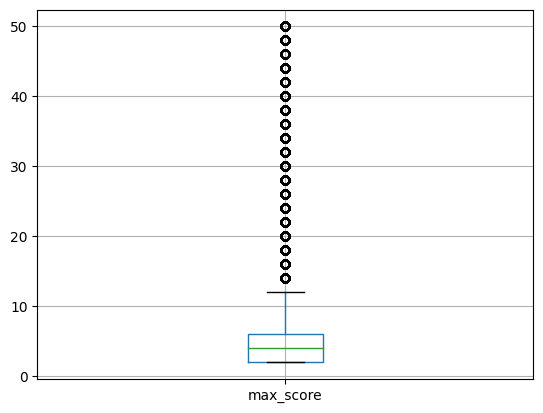

In [12]:
df[['max_score']].boxplot()

In [13]:
# for x in range(0, 40):
#   print('grav '+str(x)+' : '+str(len(df[df['gravMerged']==x])))

for x in range(0, 50):
  if len(df[df['max_score']==x])>0 :
     print('max_score '+str(x)+' : '+str(len(df[df['max_score']==x])))



max_score 2 : 382746
max_score 4 : 63729
max_score 6 : 248317
max_score 8 : 36142
max_score 10 : 7895
max_score 12 : 27725
max_score 14 : 4993
max_score 16 : 30141
max_score 18 : 8822
max_score 20 : 1810
max_score 22 : 6103
max_score 24 : 2575
max_score 26 : 661
max_score 28 : 1706
max_score 30 : 871
max_score 32 : 1421
max_score 34 : 814
max_score 36 : 366
max_score 38 : 615
max_score 40 : 373
max_score 42 : 147
max_score 44 : 272
max_score 46 : 123
max_score 48 : 197


# coreleation

<ipython-input-14-19060362bdba>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df_input.corr(), dtype=np.bool)


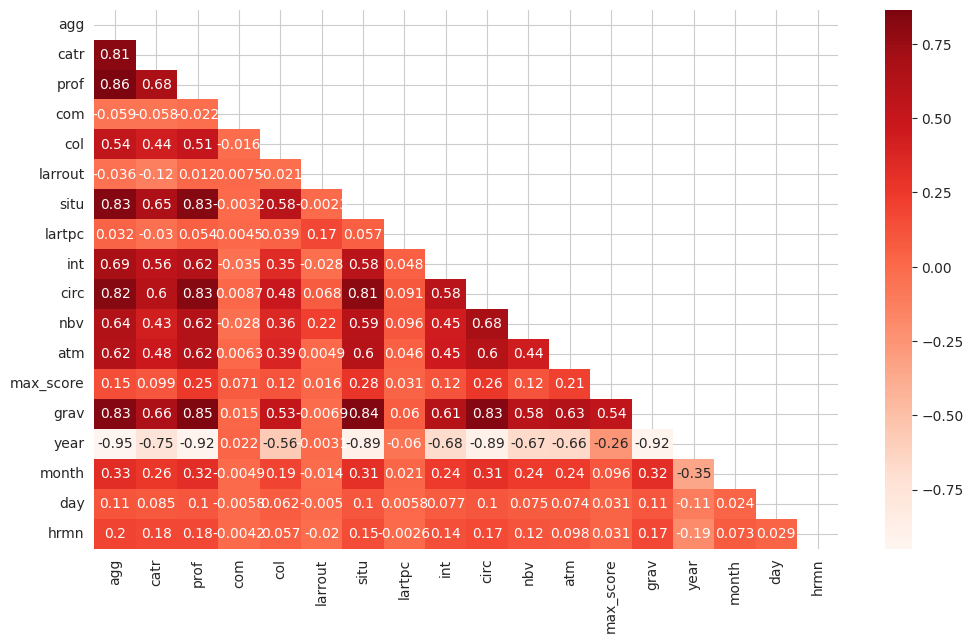

In [ ]:
#1.heatmap
def heatmap(df_input): 
    style.use('ggplot')
    sns.set_style('whitegrid')
    sns.set_style('whitegrid')
    plt.subplots(figsize = (12,7))
    #creating mask
    mask = np.zeros_like(df_input.corr(), dtype=np.bool)
    #print(mask)
    mask[np.triu_indices_from(mask)] = True  
    sns.heatmap(df_input.corr(), annot=True,mask=mask, center = 0,  cmap='Reds')
    plt.show()

heatmap(df)

# Split data set

In [14]:
# df_RF=df.copy()
# print("all years:"+str(len(df_RF)))
# df_RF_12_16 = df_RF[df_RF['DateTime'] > datetime.date(2011,12,31)]

# df_RF = df_RF[(df_RF['DateTime']>datetime.date(2011,12,31)) & (df_RF['DateTime']<datetime.date(2015,12,31))]  

# print("2012 and 2015:"+str(len(df_RF)))
# print("2012 and later:"+str(len(df_RF_12_16)))

df_RF=df.copy()
print("all years:"+str(len(df_RF)))
df_RF_12_16 = df_RF[df_RF['year'] > 2012]
df_RF = df_RF[(df_RF['year'] > 2012) & (df_RF['year'] < 2016) ]
print("2012 and 2015:"+str(len(df_RF)))
print("2012 and later:"+str(len(df_RF_12_16)))

all years:829273
2012 and 2015:171643
2012 and later:228950


In [15]:
Y =df_RF['max_score']
X = df_RF.drop(['max_score','grav'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

#shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape
Y.value_counts()


2     80187
6     51607
4     12699
8      7407
16     6357
12     5441
18     1806
10     1576
22     1211
14     1014
24      460
20      363
28      332
32      288
30      168
34      155
26      139
38      118
40       80
36       68
44       60
48       48
42       35
46       24
Name: max_score, dtype: int64

#Gradient Boosting Regressor

In [16]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
print_score(gbr)
#confusion matrix
y_pred = gbr.predict(X_test)
#classification report
print(r2_score(y_test, y_pred))
# gbr = GradientBoostingRegressor(n_estimators = 1000,
#                                 max_depth = 10000,
#                                 max_features = 15,
#                                 validation_fraction = 0)

score train 22.819 rmse train 4.305
score test 22.083 rsme test 4.370
0.2208272841778488


# NEW GBR using parameters

In [18]:
def GRADBOOSTREG(est,lr,mFeat,mDepth,sub,ran):
  gbr = GradientBoostingRegressor(
      n_estimators=est,learning_rate=lr,
      max_features=mFeat,
      max_depth=mDepth,
      subsample=sub,
      random_state=ran)
  gbr.fit(X_train, y_train)
  print_score(gbr)
  y_pred = gbr.predict(X_test)
  print(r2_score(y_test, y_pred))
  return gbr


In [29]:
for sub in[0.1]:
  print('subsample'+str(sub))
  for md in[50]:
    print('max_depth'+str(md)) 
    for nest in [1000]:
      print('n_estimators'+str(nest))
      for lr in [0.001]:
        print('learning_rate'+str(lr))
        for mf in[8]:
          print('max_features'+str(mf))
          print('-------------------------')
          GRADBOOSTREG(nest,lr,mf,md,sub,1)


subsample0.1
max_depth50
n_estimators1000
learning_rate0.001
max_features8
-------------------------
score train 34.248 rmse train 3.973
score test 20.669 rsme test 4.409
0.20668674586244484


In [ ]:
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)
GBR=GradientBoostingRegressor()
search_grid={'n_estimators':[500,1000,2000],
             'learning_rate':[.001,0.01,.1],
             'max_features': [8],
             'max_depth':[6,8,10],
             'subsample':[0.1,0.5],
             'random_state':[1]}
search=GridSearchCV(estimator=GBR,
                    param_grid=search_grid,scoring='neg_mean_squared_error',
                    n_jobs=1,
                    cv=crossvalidation)

In [ ]:
search.fit(X_train, y_train)
search.best_params_

#NEW Tree.decisiontreeregression

In [ ]:
from sklearn import tree
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)

for depth in range (1,10):
  tree_regressor=tree.DecisionTreeRegressor(max_depth=depth,random_state=1)
  score=np.mean(cross_val_score(tree_regressor,X_test,y_test,scoring='neg_mean_squared_error', cv=crossvalidation,n_jobs=1))
  print(depth, score)

#Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train[['agg']], y_train)

print("score train:",lr.score(X_train[['agg']], y_train))
print("score test:", lr.score(X_test[['agg']], y_test))

pred = lr.predict(X_train[['agg']])
pred_test = lr.predict(X_test[['agg']])

print("rmse train:", np.sqrt(mean_squared_error(y_train, pred)))
print("rmse test: ", np.sqrt(mean_squared_error(y_test, pred_test)))


score train: 0.10524396166995331
score test: 0.10374919801933669
rmse train: 4.654822358444045
rmse test:  4.627764475413755


#KNN regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor()
knnr.fit(X_train, y_train)
print_score(knnr)

#confusion matrix
y_pred_knnr = knnr.predict(X_test)
pd.crosstab(y_test, y_pred_knnr, rownames=['True'], colnames=['Predicted'])

#classification report
print(r2_score(y_test, y_pred_knnr))

# NEW KNN REGRESSOR using parameters

In [ ]:
from sklearn import decomposition, datasets
from sklearn import neighbors
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

In [ ]:
std_slc = StandardScaler()
pca = decomposition.PCA()

In [ ]:
KNN = neighbors.KNeighborsRegressor()
pipe = Pipeline(steps=[("std_slc", std_slc),
                           ("pca", pca),
                           ("KNN", KNN)])
n_components = list(range(1,X.shape[1]+1,1))
n_neighbors = [2, 3, 5, 10]
algorithm = ["auto",  "ball_tree", "kd_tree", "brute"]

parameters = dict(pca__n_components=n_components,
                      KNN__n_neighbors=n_neighbors,
                      KNN__algorithm=algorithm)
clf = GridSearchCV(pipe, parameters)
clf.fit(X_train, y_train)

In [ ]:
print("Best Number Of Components:", clf.best_estimator_.get_params()["pca__n_components"])
print(); print(clf.best_estimator_.get_params()["KNN"])
CV_Result = cross_val_score(clf, X_test, y_test, cv=3, n_jobs=-1, scoring="r2")
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

#Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
print_score(rfr)

#confusion matrix
y_pred_rfr = rfr.predict(X_test)
pd.crosstab(y_test, y_pred_rfr, rownames=['True'], colnames=['Predicted'])

#classification report
print(r2_score(y_test, y_pred_rfr))

score train 89.325 rmse train 0.196
score test 24.677 rsme test 0.523
0.24676988378570697


#NEW Random Forest Regressor using parameters

In [39]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose =3)

In [40]:
#Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


ValueError: ignored

#Support Vector Regression

In [ ]:
from sklearn.svm import SVR
svmr = SVR(kernel = 'rbf')
svmr.fit(X_train, y_train)
print_score(svmr)

#confusion matrix
y_pred_svmr = svmr.predict(X_test)
pd.crosstab(y_test, y_pred_svmr, rownames=['True'], colnames=['Predicted'])

#classification report
print(r2_score(y_test, y_pred_svmr))

score train -26.845 rmse train 0.676
score test -26.457 rsme test 0.678
-0.26457209397746984


#Decision Tree Regresor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor() 
dtr.fit(X_train, y_train)
print_score(dtr)

#confusion matrix
y_pred_dtr = dtr.predict(X_test)
pd.crosstab(y_test, y_pred_dtr, rownames=['True'], colnames=['Predicted'])

#classification report
print(r2_score(y_test, y_pred_dtr))

score train 99.991 rmse train 0.046
score test -64.414 rsme test 6.316
-0.6441394164107435


# RIDGE & LASSO

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LassoCV,LinearRegression,RidgeCV
import matplotlib.pyplot as plt


In [ ]:
"""# RIDGE"""
alphas= [0.01, 0.05, 0.1, 0.3, 0.8, 1, 1.5, 2.5, 3, 4, 5]
ridge_reg = RidgeCV(alphas= alphas)

ridge_reg.fit(X_train, y_train)

##print( "alpha selected by c-v :" ,ridge_reg.alpha_)
print("score train :", ridge_reg.score(X_train, y_train))
print("score test :", ridge_reg.score(X_test, y_test))


ridge_pred_train = ridge_reg.predict(X_train)
ridge_pred_test = ridge_reg.predict(X_test)

print("mse train:", mean_squared_error(ridge_pred_train, y_train))
print("mse test:", mean_squared_error(ridge_pred_test, y_test))


score train : 0.12944591733503985
score test : 0.1323143073094566
mse train: 20.97629243876091
mse test: 21.05141074333137


In [ ]:
# creation of RMSE_CV function
def rmse_cv(model,XIn,Yin,cv):
  scores = cross_val_score(model, XIn, Yin, scoring = 'neg_mean_squared_error',
                         cv = cv, n_jobs = -1)
  meanscore=np.mean(np.sqrt(np.abs(scores)))
  #print(scores) 
  #print(meanscore) 
  return meanscore

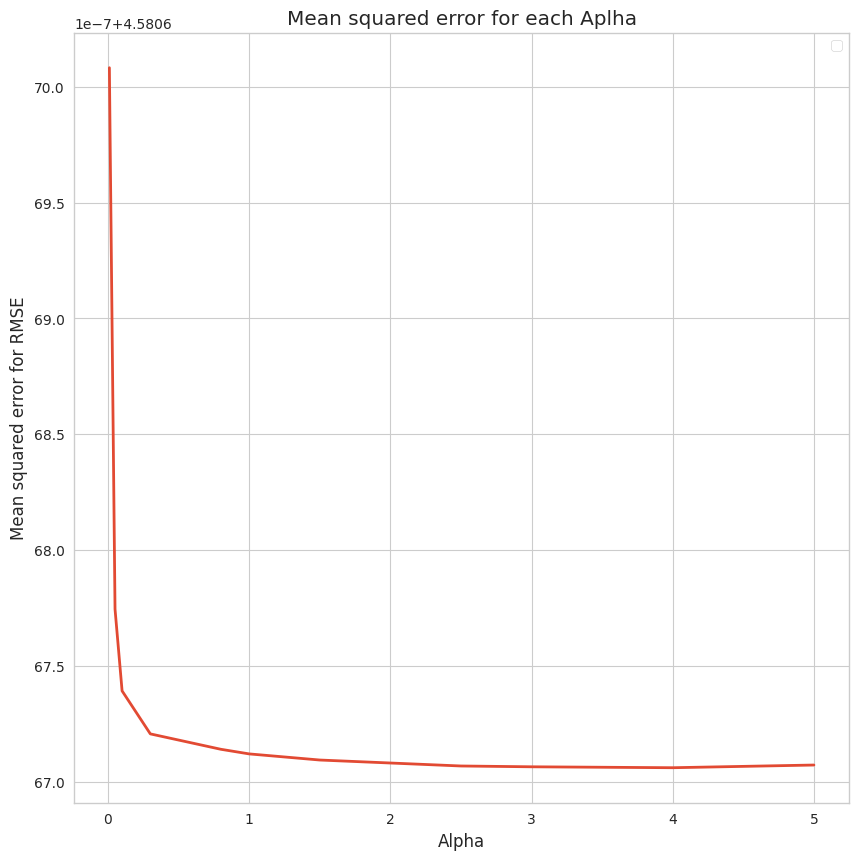

In [ ]:
#plot RSME
rmse_score=[]
for aa in alphas:
  tempridge_reg=RidgeCV(aa)
  tempridge_reg.fit(X_train, y_train)
  rmse_score.append(rmse_cv(tempridge_reg,X_train,y_train,5))
  #print('aa: '+str(aa)+' rmse score: '+str(rmse_score))
plt.figure(figsize = (10,10))
plt.plot(alphas,rmse_score, linewidth=2)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean squared error for RMSE')
plt.title('Mean squared error for each Aplha')
plt.show()


In [ ]:
#Powerful Ridge regression
ridge_reg = RidgeCV(alphas= 5)
ridge_reg.fit(X_train, y_train)
print("score test for powerful Ridge regression model :", ridge_reg.score(X_test, y_test))
ridge_pred_test = ridge_reg.predict(X_test)
print("mse test for powerful Ridge regression model:", mean_squared_error(ridge_pred_test, y_test))


score test for powerful Ridge regression model : 0.1323143073094566
mse test for powerful Ridge regression model: 21.05141074333137


In [ ]:
"""# Lasso """

my_alphas =[1, 0.5, 0.1, 0.1, 0.001, 0.0005]

regLasso = LassoCV(cv=5, random_state=0,alphas=my_alphas)
regLasso.fit(X_train, y_train)
#regLasso.alpha_
print("score train for Lasso model :", regLasso.score(X_train, y_train))
print("score test for Lasso model :", regLasso.score(X_test, y_test))
regLasso_test = regLasso.predict(X_test)
print("mse test for Lasso model:", mean_squared_error(regLasso_test, y_test))


score train for Lasso model : 0.12944479952351484
score test for Lasso model : 0.13229494664981167
mse test for Lasso model: 21.051880463187167


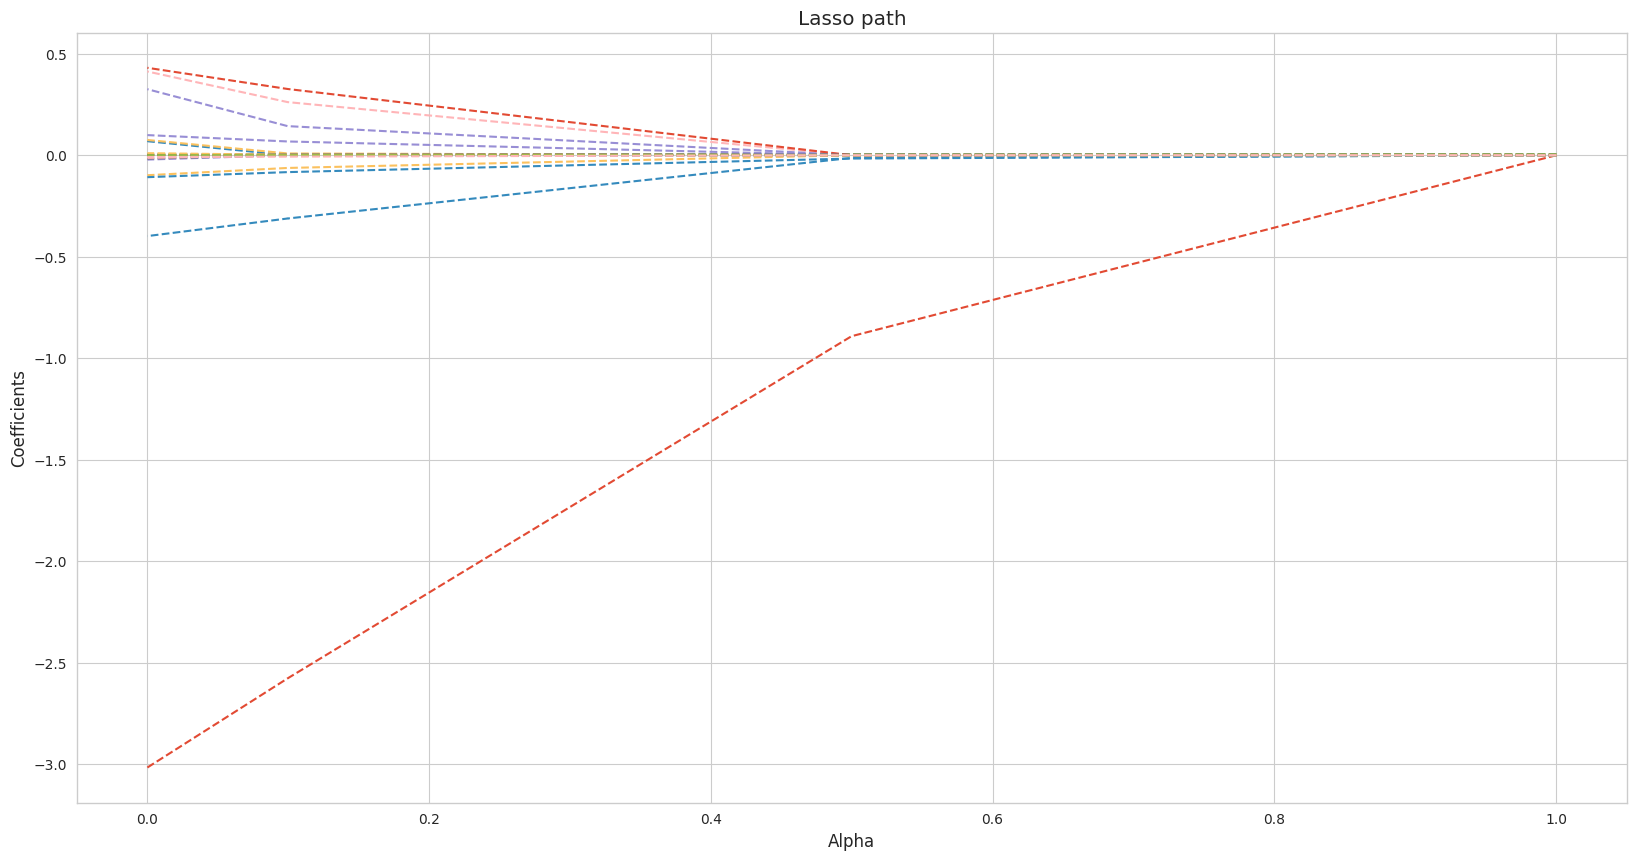

In [ ]:
#Ploting the curve of the number of variables kept and the number of variables eliminated by the model

from sklearn.linear_model import lasso_path
alpha_path, coefs_lasso, _ =lasso_path(X_train, y_train, alphas=my_alphas)

coefs_lasso.shape
plt.figure(figsize=(20,10))
for i in range(coefs_lasso.shape[0]):
    plt.plot(alpha_path, coefs_lasso[i,:], '--')

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path')
plt.show()


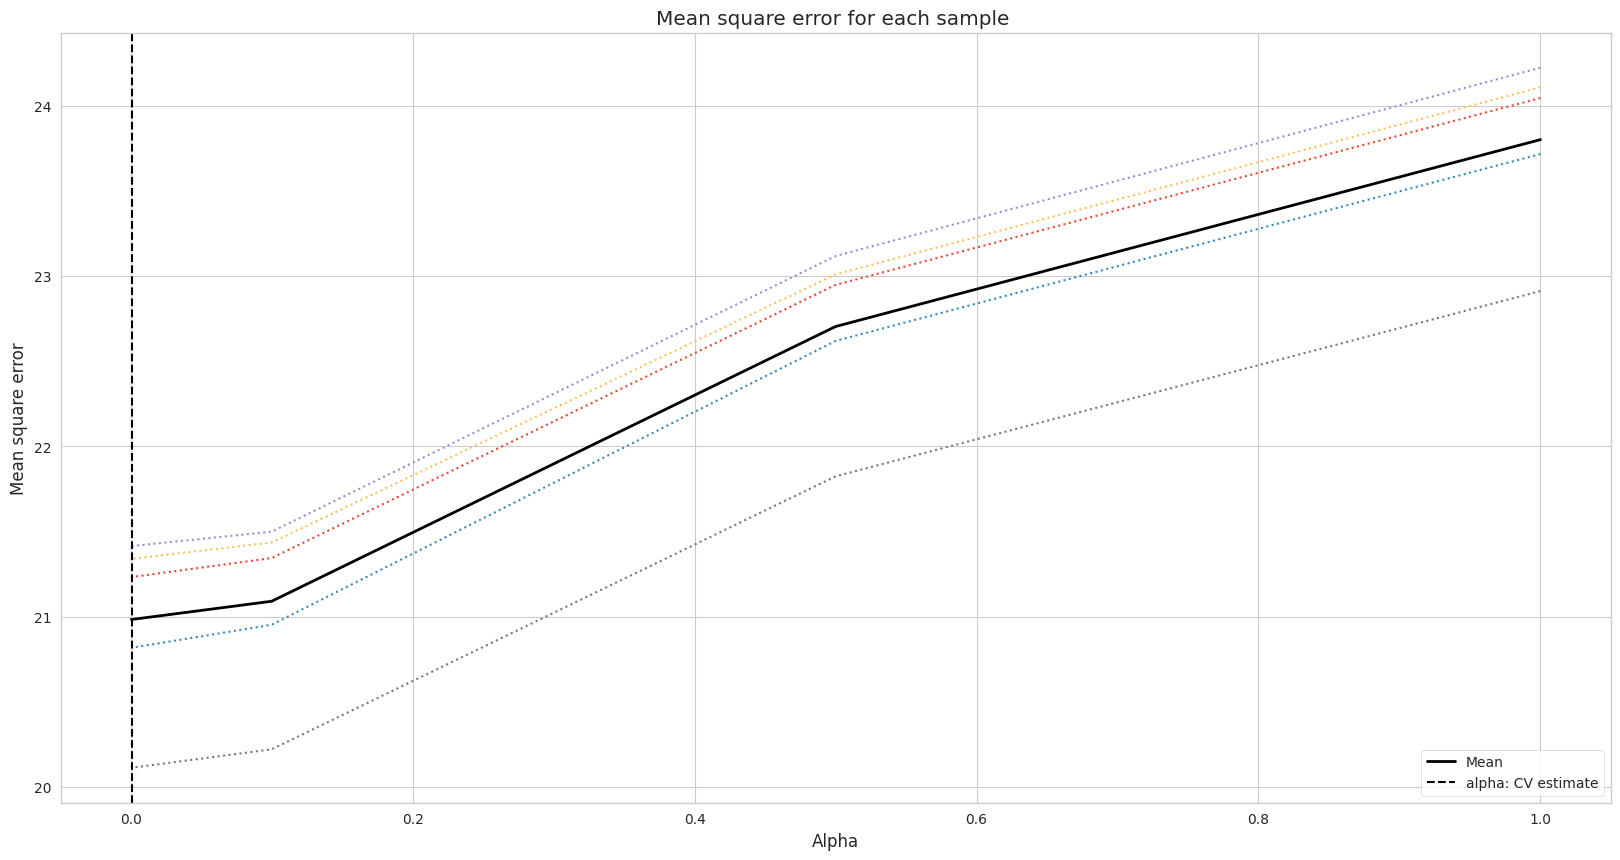

In [ ]:
alphas = regLasso.alphas_

plt.figure(figsize = (20,10))

plt.plot(alphas, regLasso.mse_path_, ':')

plt.plot(alphas, regLasso.mse_path_.mean(axis=1), 'k',
         label='Mean', linewidth=2)

plt.axvline(regLasso.alpha_, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('Alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error for each sample ')
plt.show()


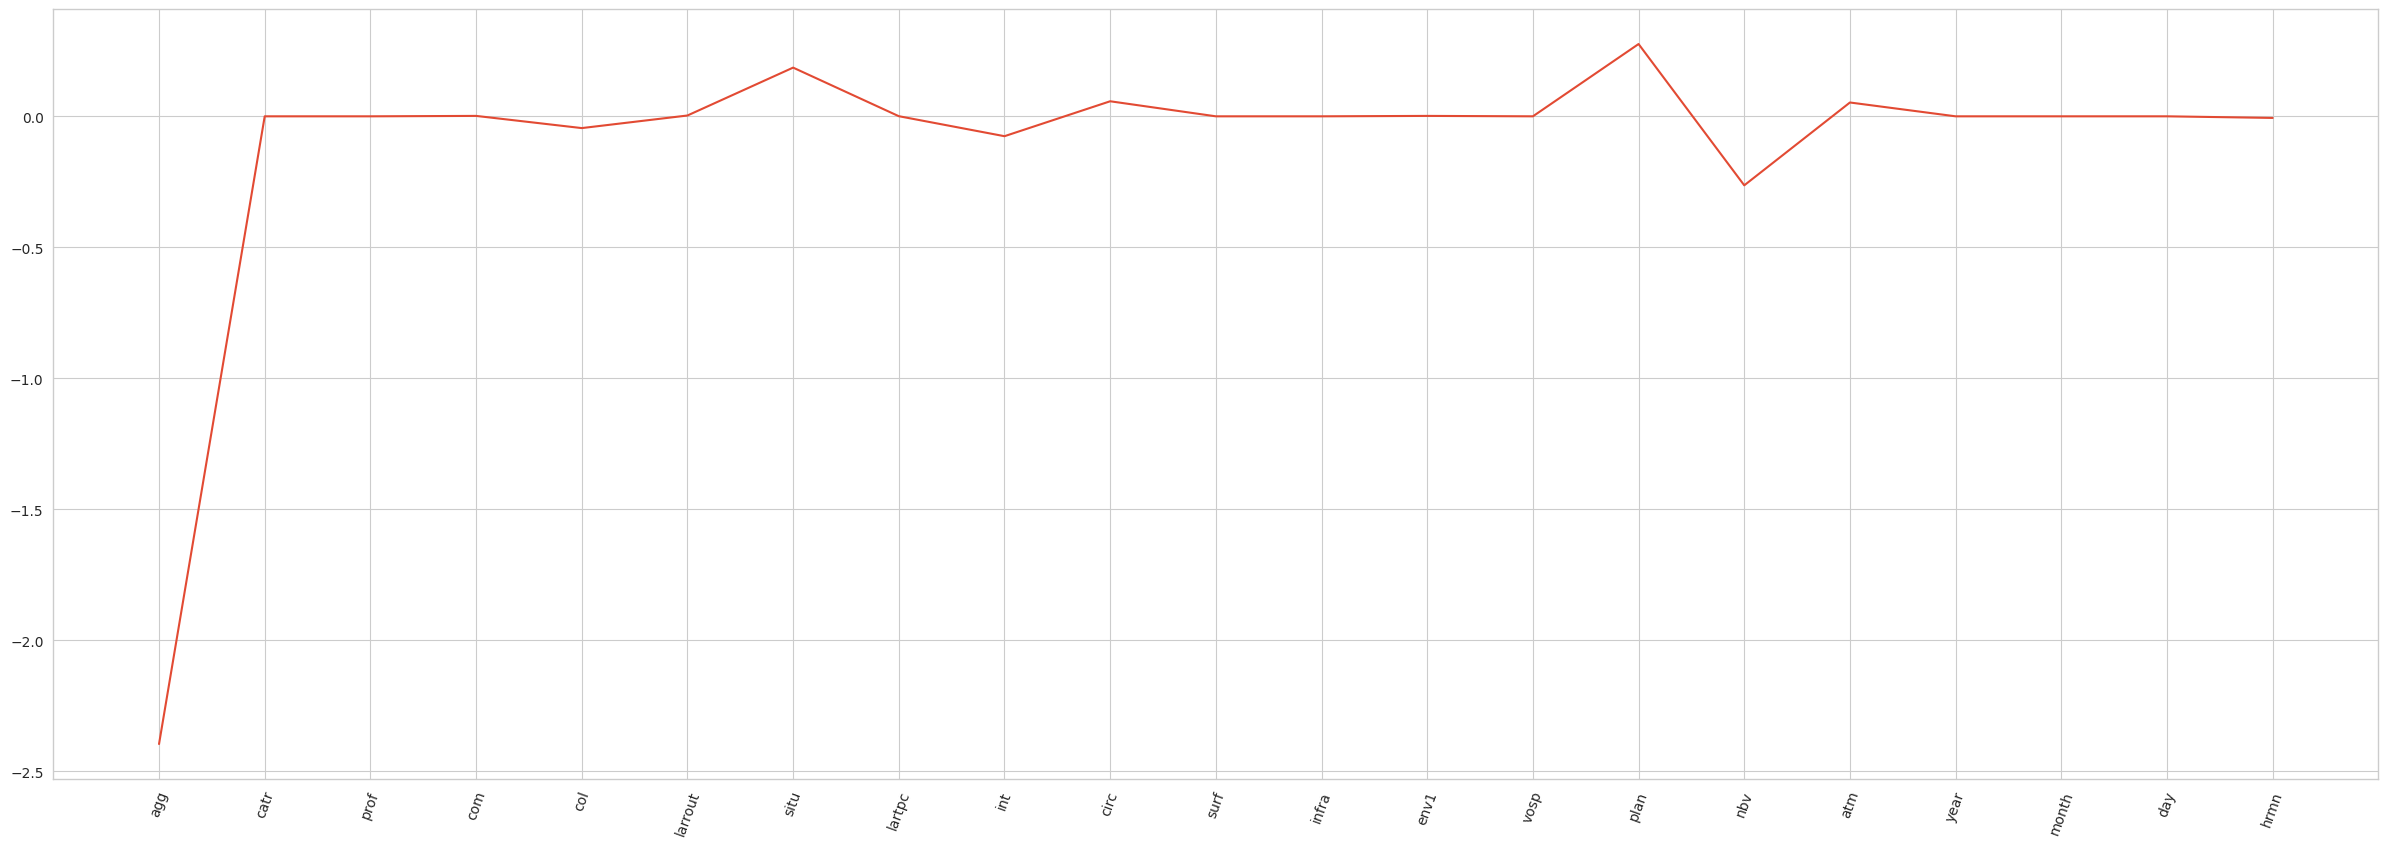

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.15)

lasso_reg.fit(X_train, y_train)

lasso_coef = lasso_reg.coef_
xcolumns=X_train.columns
plt.figure(figsize=(30,10))
plt.plot(range(len(xcolumns)), lasso_coef)
plt.xticks(range(len(xcolumns)), X_train.columns.values, rotation=70)
plt.show()


In [ ]:
pred_test = regLasso.predict(X_test)

print("score test:", regLasso.score(X_test, y_test))
print("mse test:", mean_squared_error(pred_test, y_test))

score test: 0.13229494664981167
mse test: 21.051880463187167


#Elastic Net

In [ ]:
scaler = preprocessing.StandardScaler().fit(df_RF)

In [ ]:
from sklearn.linear_model import ElasticNetCV

model_en = ElasticNetCV(cv=8, l1_ratio = (0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas= (0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0))
model_en.fit(X_train, y_train)


ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99))

In [ ]:
coeffs = list(model_en.coef_)
coeffs.insert(0, model_en.intercept_)
feats = list(X.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'Estimated values': coeffs}, index = feats)


,Estimated values
intercept,13.711803
agg,-3.015268
catr,0.068656
prof,-0.021500
com,0.001269
col,-0.098444
larrout,0.003007
situ,0.411768
lartpc,0.000100
int,-0.108077


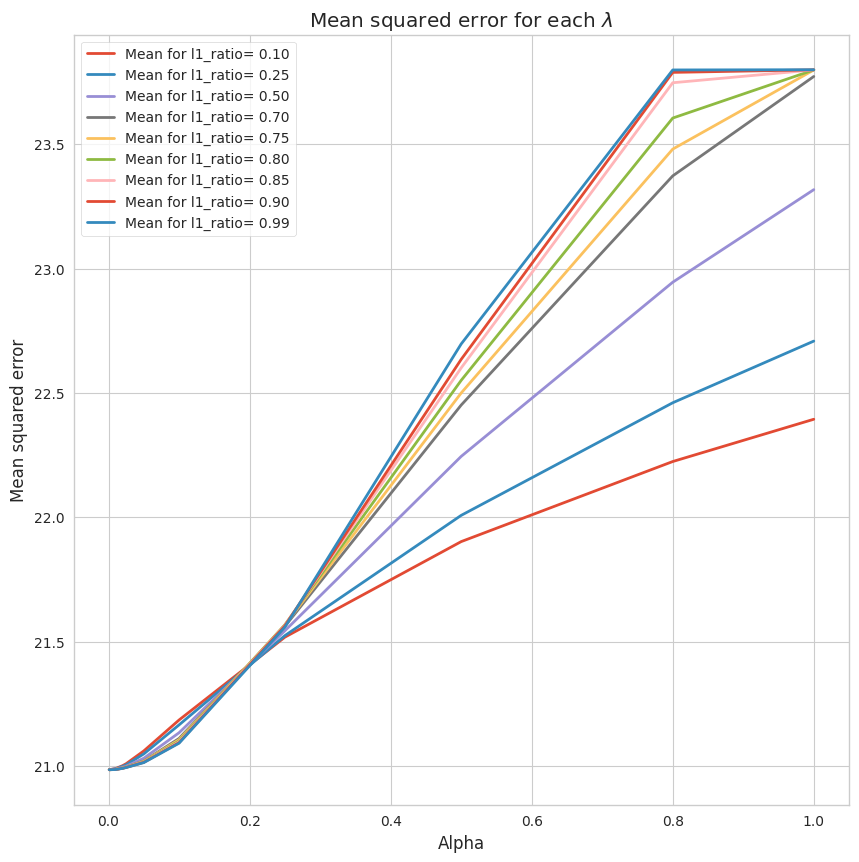

In [ ]:
alphas = model_en.alphas_

plt.figure(figsize = (10,10))

for i in range(model_en.mse_path_.shape[0]) :
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1),
         label='Mean for l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)

plt.legend()

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error for each $\lambda$')
plt.show()


In [ ]:
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)
print("rmse train:", np.sqrt(mean_squared_error(y_train, pred_train)))
print('rmse test:', np.sqrt(mean_squared_error(y_test, pred_test)))


rmse train: 4.579991188206144
rmse test: 4.588233057110674


In [ ]:
print("score train:",model_en.score(X_train, y_train))
print("score test:", model_en.score(X_test, y_test))


score train: 0.12944480320714824
score test: 0.13229485913788863


In [ ]:
mean = scaler.mean_[-1]
std = scaler.scale_[-1]
print("mean :", mean)
print("std", std)


mean : 13.500171918434901
std 5.394740795347528


In [ ]:
pd.DataFrame({'Observed max_score': (y_test*std)+mean, 'Predicted max_score' : np.round((pred_test*std)+mean)}, index = X_test.index).head(7)

,Observed max_score,Predicted max_score
168077,24.289654,58.0
139477,24.289654,36.0
70421,24.289654,39.0
77876,45.868617,46.0
221836,24.289654,34.0
101464,24.289654,41.0
114597,24.289654,41.0


# Prediction

In [ ]:
#preparation for prediction
df_RF_16 = df_RF_12_16[df_RF_12_16['year'] > 2015]
X_RF_16 = df_RF_16.drop(['grav','gravMerged'], axis = 1)

In [ ]:
pred = gbc.predict(X_RF_16)

In [ ]:
grav_series=df_RF_16.grav

In [ ]:
grav_series=grav_series.replace(0,2)


In [ ]:
pred[pred == 0] = 2

In [ ]:
print(grav_series.iloc[72])

1


In [ ]:
# Relative average error

RAE = [(grav_series.iloc[i]-pred[i])/grav_series.iloc[i] for i in range(len(grav_series))]
bias = sum(RAE) / len(grav_series)
print('Bias: %f%%' % (bias*100))

"""Relative average error can be positive and negative. This means that when the average of these values is calculated, an ideal mean forecast error would be zero.
A relative average error value other than zero suggests a tendency of the model to over forecast (negative error) or under forecast (positive error).
Here the result is negative meaning the prediction over estimate the actual values of the series"""

Bias: -11.803267%


'Relative average error can be positive and negative. This means that when the average of these values is calculated, an ideal mean forecast error would be zero.\nA relative average error value other than zero suggests a tendency of the model to over forecast (negative error) or under forecast (positive error).\nHere the result is negative meaning the prediction over estimate the actual values of the series'

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(mean_squared_error(grav_series, pred))  # MSE

print(mean_squared_error(grav_series, pred, squared=False)) # RMSE

print(mean_absolute_error(grav_series, pred)) # MAE

"""MSE, RMSE and MAE are all positive meaning prediction over estimate the actual values of the series. Here we got also the same result as retrieve with Mean Forecast Error"""

0.27426469306274737
0.5237028671515437
0.27426469306274737


'MSE, RMSE and MAE are all positive meaning prediction over estimate the actual values of the series. Here we got also the same result as retrieve with Mean Forecast Error'

# display

In [ ]:
#Feature Importance
f_imp = pd.DataFrame(data={'importance':gbr.feature_importances_,'features':X_train.columns}).set_index('features')
f_imp = f_imp.sort_values('importance', ascending=False)
f_imp.head(20)

,importance
features,
max_score,9.951412e-01
col,3.165632e-03
nbv,7.483401e-04
catr,3.802639e-04
larrout,1.241113e-04
circ,9.695144e-05
lartpc,9.496151e-05
agg,8.625951e-05
com,5.002633e-05


<Axes: xlabel='features'>

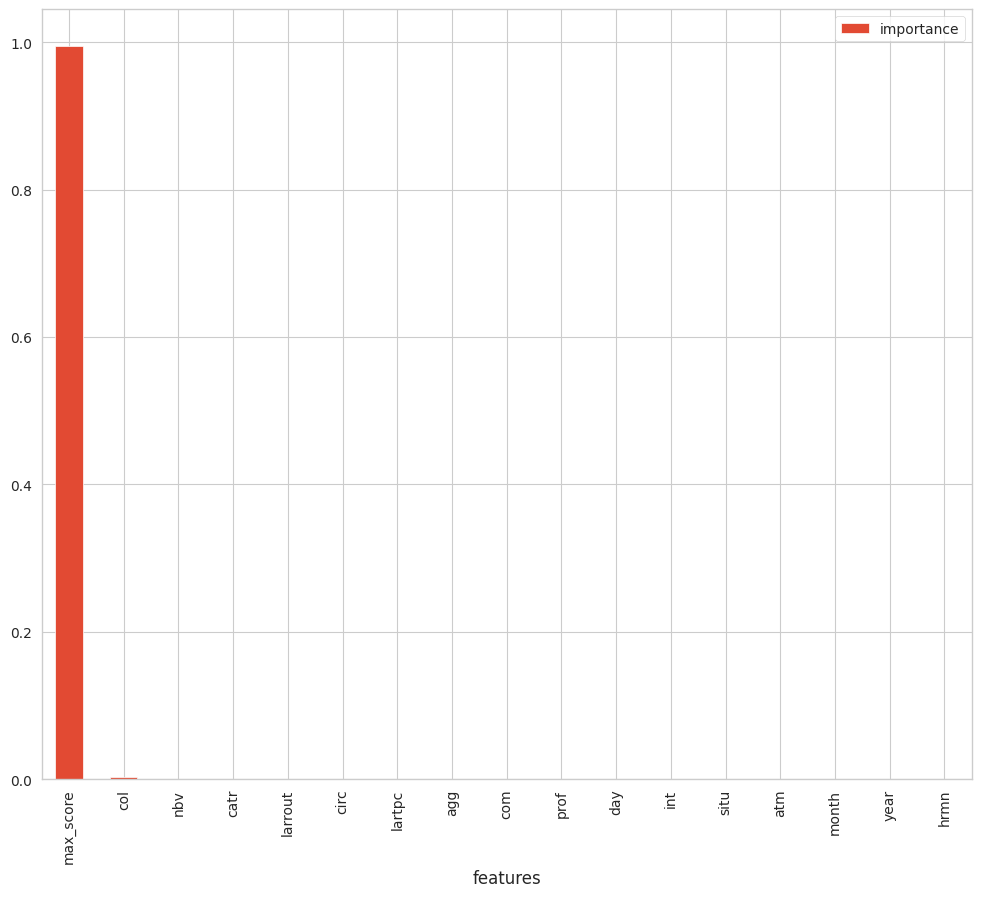

In [ ]:
f_imp[:20].plot(kind='bar', figsize=(12,10))